# 毕达哥拉斯三体问题

## 问题的陈述

“勾三股四弦五”是经典的毕达哥拉斯的一个特例。人们在研究三体问题的时候，尝试把三个星体摆放到边长分别是 3、4、5 的直角三角形的顶点之上，三个星体的质量分别是对边的长度，初始速度都为零，然后看系统轨道的演化，出乎人们的意料，轨道呈现出非常复杂的图案。


## 定义系统的演化函数

In [1]:
import numpy as np
import wq.core.physics.unit.au as au

from math import sqrt
from wq.core.math.ode import verlet as solver
from wq.core.physics.nbody.body3p import accelerationOf

accel = accelerationOf(au, 5.0, 3.0, 4.0)
step = solver(accel)

time = 0
x = np.array([0.0, 0.0, 0.0, 4.0, 3.0, 0.0])
v = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

cx = 4.0 * 3.0 / (5.0 + 3.0 + 4.0)
cy = 3.0 * 4.0 / (5.0 + 3.0 + 4.0)

K = 0.0
U = - au.G * (5.0 * 4.0 / 3.0 + 3.0 * 5.0 / 4.0 + 3.0 * 4.0 / 5.0)
E = K + U

def evolve(tao):
    global time, x, v, K, U, E

    time, x, v = step(time, x, v, tao)
    x1  = x[0]
    y1  = x[1]
    x2  = x[2]
    y2  = x[3]
    x3  = x[4]
    y3  = x[5]
    vx1 = v[0]
    vy1 = v[1]
    vx2 = v[2]
    vy2 = v[3]
    vx3 = v[4]
    vy3 = v[5]

    r12 = sqrt((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))
    r13 = sqrt((x1 - x3) * (x1 - x3) + (y1 - y3) * (y1 - y3))
    r23 = sqrt((x2 - x3) * (x2 - x3) + (y2 - y3) * (y2 - y3))

    v1 = sqrt(vx1 * vx1 + vy1 * vy1)
    v2 = sqrt(vx2 * vx2 + vy2 * vy2)
    v3 = sqrt(vx3 * vx3 + vy3 * vy3)

    K = (5.0 * (vx1 * vx1 + vy1 * vy1) + 3.0 * (vx2 * vx2 + vy2 * vy2) + 4.0 * (vx3 * vx3 + vy3 * vy3)) /2
    U = - au.G * (5.0 * 3.0 / r12 + 5.0 * 4.0 / r13 + 3.0 * 4.0 / r23)
    E = K + U

    dx = (5.0 * x1 + 3.0 * x2 + 4.0 * x3) / (5.0 + 3.0 + 4.0) - cx
    dy = (5.0 * y1 + 3.0 * y2 + 4.0 * y3) / (5.0 + 3.0 + 4.0) - cy

    x[0] = x[0] - dx
    x[1] = x[1] - dy
    x[2] = x[2] - dx
    x[3] = x[3] - dy
    x[4] = x[4] - dx
    x[5] = x[5] - dy

    return min(r12, r13, r23), max(v1, v2, v3)

## 绘制系统演化的轨迹图

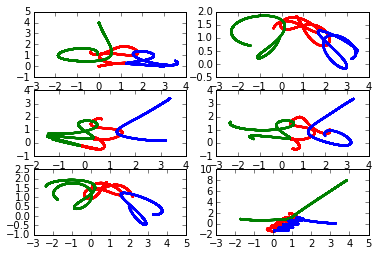

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

serial_time = [time]
serial_x1 = [0]
serial_y1 = [0]
serial_x2 = [0]
serial_y2 = [4]
serial_x3 = [3]
serial_y3 = [0]
serial_energy = [E]

dt = 0.1
for i in range(6):
    for j in range(5000):
        minDist, maxVelo = evolve(dt)
        dt = min(minDist / maxVelo / 100, 0.1)

        x1 = x[0]
        y1 = x[1]
        x2 = x[2]
        y2 = x[3]
        x3 = x[4]
        y3 = x[5]

        serial_time.append(time)
        serial_x1.append(x1)
        serial_y1.append(y1)
        serial_x2.append(x2)
        serial_y2.append(y2)
        serial_x3.append(x3)
        serial_y3.append(y3)
        serial_energy.append(E)

    plt.subplot(321+i)
    plt.scatter(serial_x1, serial_y1, facecolor='r', edgecolor='none', marker='.')
    plt.scatter(serial_x2, serial_y2, facecolor='g', edgecolor='none', marker='.')
    plt.scatter(serial_x3, serial_y3, facecolor='b', edgecolor='none', marker='.')

    serial_time = [serial_time[-1]]
    serial_x1 = [serial_x1[-1]]
    serial_y1 = [serial_y1[-1]]
    serial_x2 = [serial_x2[-1]]
    serial_y2 = [serial_y2[-1]]
    serial_x3 = [serial_x3[-1]]
    serial_y3 = [serial_y3[-1]]
    serial_energy = [serial_energy[-1]]
        
plt.show()

## 尝试动画的效果

In [2]:
import base64

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)
    
    return VIDEO_TAG.format(anim._encoded_video)

In [3]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [4]:
import matplotlib.pyplot as plt

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-3, 5), ylim=(-2, 8))

liner, = ax.plot([], [], lw=2)
lineg, = ax.plot([], [], lw=2)
lineb, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    liner.set_data([0], [0])
    lineg.set_data([0], [4])
    lineb.set_data([3], [0])
    return [liner, lineg, lineb]

# animation function.  This is called sequentially
dt = 0.1
def animate(i):
    global dt
    minDist, maxVelo = evolve(dt)
    dt = min(minDist / maxVelo / 100, 0.1)

    x1 = x[0]
    y1 = x[1]
    x2 = x[2]
    y2 = x[3]
    x3 = x[4]
    y3 = x[5]

    liner.set_data([x1], [y1])
    lineg.set_data([x2], [y2])
    lineb.set_data([x3], [y3])

    return [liner, lineg, lineb]


In [6]:
%matplotlib inline

from matplotlib import animation

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)